# Анализ предпочтений и спроса пользователей авиакомпании

**Цель проекта:** понять предпочтения пользователей, покупающих билеты на те или иные направления.

**Задачи проекта:** 
- понять предпочтения пользователей, покупающих билеты на те или иные направления
- изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали

**Описание данных:** у нас есть данные российской авиакомпании «F9», которая выполняет внутренние пассажирские авиаперевозки.

В базе данных нет прямой связи между таблицами airports и festivals, а также festivals и flights, но эти таблицы можно связать по городу проведения фестиваля (festival_city) и городу аэропорта (city). В flights потребуется некоторое преобразование дат, чтобы связать  по дате проведения фестиваля (festival_date). 

#### Содержание базы данных об авиаперевозках:

Таблица **airports** — информация об аэропортах:
- airport_code — трёхбуквенный код аэропорта
- airport_name — название аэропорта
- city — город
- timezone — временная зона

Таблица **aircrafts** — информация о самолётах:
- aircraft_code — код модели самолёта
- model — модель самолёта
- range — количество самолётов

Таблица **tickets** — информация о билетах:
- ticket_no — уникальный номер билета
- passenger_id — персональный идентификатор пассажира
- passenger_name — имя и фамилия пассажира

Таблица **flights** — информация о рейсах:
- flight_id — уникальный идентификатор рейса
- departure_airport — аэропорт вылета
- departure_time — дата и время вылета
- arrival_airport — аэропорт прилёта
- arrival_time — дата и время прилёта
- aircraft_code – id самолёта

Таблица **ticket_flights** — стыковая таблица «рейсы-билеты»
- ticket_no — номер билета
- flight_id — идентификатор рейса

Таблица **festivals** — информация о фестивалях
- festival_id — уникальный номер фестиваля
- festival_date — дата проведения фестиваля
- festival_city — город проведения фестиваля
- festival_name — название фестиваля

---


В таблице **/datasets/query_1.csv** — информация о:
- model — модели самолета
- flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года

В таблице **/datasets/query_3.csv** — информация о:
- city — городах
- average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года

#### План анализа:
- Обзор и подготовка данных (анализ и обработка ошибок).
- Провести исследовательский анализ данных (выбрать топ-10 городов по количеству рейсов)
- Визуализировать полученные данные (модели самолетов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов).
- Итоговый вывод и рекомендации.

### Оглавление

1. [Обзор и подготовка данных](#one) </n>
2. [Исследовательский анализ данных](#two)
3. [Визуализация результатов](#three)
4. [Итоговый вывод](#fore)

----

# <a id="one"> Обзор и подготовка данных</a>

Посмотрим данные и определим в порядке ли они.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

models_data = pd.read_csv('/datasets/query_1.csv')
city_data = pd.read_csv('/datasets/query_3.csv')

In [2]:
#количество рейсов для каждой модели самолетов model в сентябре 2018 года

models_data.info()
models_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


### Комментарий

В таблице models_data всего восемь моделей самолетов, пропусков нет, типы данных правильные, дубликатов и других ошибок нет.

In [3]:
#среднее количестве рейсов, прибывающих в город city за день в августе 2018 года

city_data.info()
city_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [4]:
#поиск пропусков
city_data.isnull().sum()

city               0
average_flights    0
dtype: int64

In [5]:
#поиск дубликатов
city_data.duplicated().sum()
city_data['city'].duplicated().sum()

0

### Комментарий

В таблице city_data 101 значение, типы данных правильно. Я думаю, что пока стоит оставить тип данных float64, так как при средних значения десятичная часть может «иметь вес». Пропусков и дубликатов нет.

## Промежуточный вывод

В целом данные в порядке и готовы к анализу.

---

# <a id="two"> Исследовательский анализ данных</a>

Исходя из данных в таблице мы можем сопоставить показатели полетов с датами крупнейших фестивалей, и определить есть ли связь между двумя этими показателями.

Для этого достанем с сайта таблицу с фестивалями, чтобы было легче сравнивать результаты. Воспользуемся библиотекой BeautifulSoup

In [6]:
#обработаем URL для работы с HTML тегами

URL='https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL) 
soup = BeautifulSoup(req.text, 'lxml')

#укажем тег в котором находятся нужные нам данные

table = soup.find('table',attrs={"id": "best_festivals"})

#соберем информация для содержания столбцов и с их названиями

content=[] 
for row in table.find_all('tr'): 
    if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])
            
heading_table = [] 
for row in table.find_all('th'): 
        heading_table.append(row.text) 

#сделам из полученных данных DataFrame
        
festivals = pd.DataFrame (data = content, columns = heading_table)

festivals

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


## Топ-10 городов по количеству рейсов

Посмотрим какие города лидируют по среднему количеству рейсов, прибывающих в город за день в августе 2018 года.

In [7]:
top_10_city_average = city_data.sort_values(by='average_flights', ascending=False).head(10)
top_10_city_average

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


### Комментарий

Три из одиннадцати крупнейших фестивалей проходят в Москве (правда только один из них в августе, а мы анализируем количество прилетов именно в августе), на втором месте Санкт-Петербург, где проходят два фестиваля из одиннадцати. И именно они лидируют по количеству рейсов, однако нельзя утверждать, что здесь есть зависимость. Например, в Новосибирске вообще нет фестивалей, а он находится на третьем месте.

## Промежуточный вывод

По количеству рейсов лидируют два крупнейших российских города, а также один из центральных городов Сибири, так что не удивительно, что здесь такое большое количество рейсов. В остальных же городах количество примерно одинаковое — от 11 до 9 рейсов. Пока невозможно отметить какую-либо зависимость между проведением фестивалей и увеличением числа рейсов в города их проведения.

---

# <a id="three"> Визуализация результатов</a>

Посмотрим как распределены показатели на графиках, чтобы найти другие закономерности.

## Модели самолетов и количество рейсов

Посмотрим какие модели наиболее часто используют для рейсов в России. Основной показатель — количество рейсов для каждой модели самолетов в сентябре 2018 года.

In [8]:
#отсортируем по количеству полетов
models_data = models_data.sort_values(by='flights_amount', ascending=False)
models_data

,model,flights_amount
6,Cessna 208 Caravan,4557
5,Bombardier CRJ-200,4446
7,Sukhoi SuperJet-100,4185
1,Airbus A321-200,960
2,Boeing 737-300,630
0,Airbus A319-100,607
3,Boeing 767-300,600
4,Boeing 777-300,300


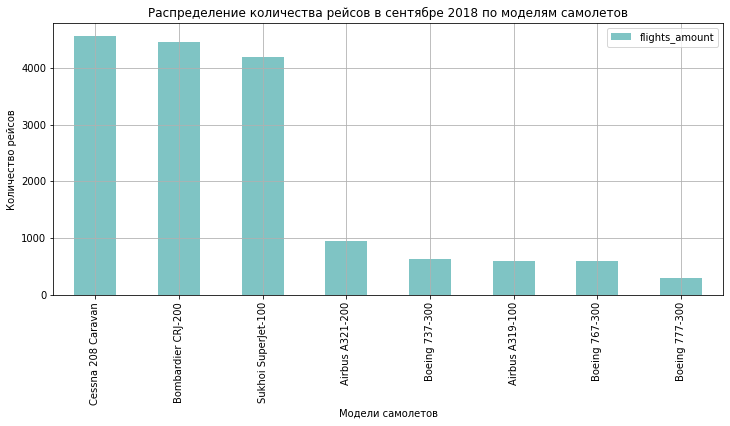

In [9]:
#построим график по количеству рейсов для каждой модели самолета
models_data.plot(x='model', y='flights_amount', kind='bar', alpha=0.5, color='darkcyan', figsize=(12,5), grid=True);

plt.title('Распределение количества рейсов в сентябре 2018 по моделям самолетов')
plt.xlabel('Модели самолетов')
plt.ylabel('Количество рейсов')

plt.show()

### Комментарий

Значительно больше полетов у трех моделей (больше 4000 полетов):
- **Cessna 208 Caravan** — лёгкий одномоторный турбовинтовой самолёт общего назначения (экипаж самолёта состоит из одного пилота, базовая модель перевозит девять пассажиров). В России его [используют пять операторов](https://ru.wikipedia.org/wiki/Cessna_208#%D0%93%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD%D1%81%D0%BA%D0%B8%D0%B5_%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D1%8B) (ПАНХ, Татарстан, Ак Барс Аэро, АэроГео, ТомскАвиа)

- **Bombardier CRJ-200** — региональный самолёт канадской компании Bombardier. Основными эксплуатантами в Евразии являются RusLine и SCAT(авиакомпания Казахстана).

- **Sukhoi SuperJet-100** — российский ближнемагистральный узкофюзеляжный пассажирский самолёт. [Эксплуатанты](https://ru.wikipedia.org/wiki/Sukhoi_Superjet_100): Аэрофлот, Ямал, Азимут, Газпром авиа, ИрАэро, Якутия, Северсталь, МЧС России, СЛО «Россия».

---

## Города и количество рейсов

Сделать график по более чем ста городам будет неправильно, ведь будет сложно его читать, поэтому поставим ограничение — оставим только те города, в которых среднее количество рейсов прибывающих в город за день в августе 2018 года больше трех, так как именно в этот промежуток попадет половина городов с наибольшим количество. Остальные города имеют практически одинаковые показатели и найти закономерности на их примере вряд ли получится.

In [10]:
city_data.query('average_flights > 3').count()

city               49
average_flights    49
dtype: int64

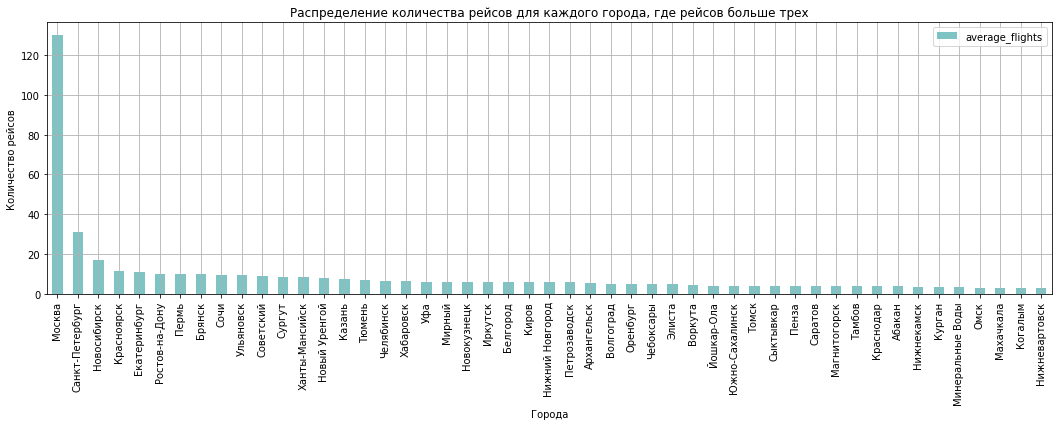

In [11]:
#распределние по всем городам по среднему количеству рейсов
city_data = city_data.sort_values(by='average_flights', ascending=False)
(city_data
 .query('average_flights > 3 ')
 .plot(x='city', y='average_flights', kind='bar', alpha=0.5, color='darkcyan', figsize=(18,5), grid=True)
)

plt.title('Распределение количества рейсов для каждого города, где рейсов больше трех')
plt.xlabel('Города')
plt.ylabel('Количество рейсов')

plt.show()

### Комментарий

Кроме первых трех городов выбросов или каких-то необычных значений нет — в среднем количество рейсов меньше 10 в день, а в некоторых городах не превышает и пяти. Нет заметной зависимости между количеством рейсов и городами проведения фестивалей. Посмотрим распределение по 10 лидирующим городам. 

## Топ-10 городов и количество рейсов

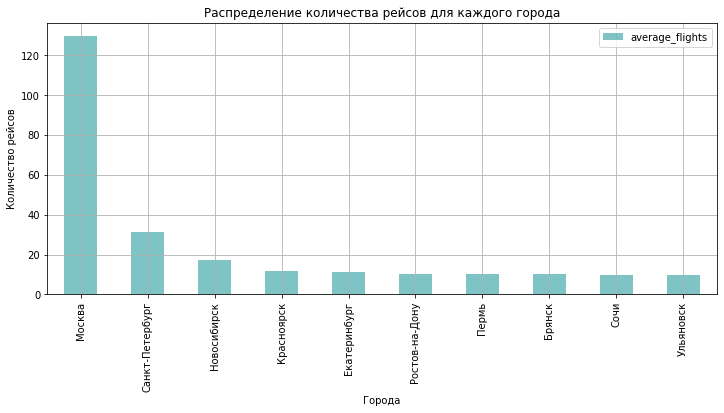

In [12]:
#построим график по количеству рейсов для топ-10 городов
top_10_city_average.plot(x='city', y='average_flights', kind='bar', alpha=0.5, color='darkcyan', figsize=(12,5), grid=True);

plt.title('Распределение количества рейсов для каждого города')
plt.xlabel('Города')
plt.ylabel('Количество рейсов')

plt.show()

## Промежуточный вывод

**Москва** имеет очень большое пиковое значение, вероятно потому, что это столица страны и многие пересадки происходят здесь. То же можно сказать и про **Санкт-Петербург**. Аэропорт в **Новосибирске** — крупнейший за Уралом по пассажиропотоку. Аэропорт находится на пересечении большого числа воздушных линий, идущих из Юго-Восточной Азии в Европу и из Северной Америки в Индию и Азию, так что большое количество рейсов здесь также имеет очевидную причину. По остальным городам показатели примерно одинаковые. Необычных показателей нет.

---

# <a id="fore"> Итоговый вывод</a>

### Цель проекта

По данным мы должны были понять предпочтения пользователей, покупающих билеты на те или иные направления и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

### Анализ рейсов по разным направлениям 

Самое большое количество рейсов был совершено в **Москве, Санкт-Петербурге и Новосибирске**.

Москва имеет очень большое пиковое значение, вероятно потому, что это столица страны и многие пересадки происходят здесь. То же можно сказать и про Санкт-Петербург. Аэропорт в Новосибирске — крупнейший за Уралом по пассажиропотоку. Аэропорт находится на пересечении большого числа воздушных линий, идущих из Юго-Восточной Азии в Европу и из Северной Америки в Индию и Азию, так что большое количество рейсов здесь также имеет очевидную причину. По остальным городам показатели примерно одинаковые. Необычных показателей нет.

### Города, где проходят фестивали

Каких-то значимых замечаний по этим данным мы не заметили, но мы сможем сказать больше, если получим данные за несколько месяцев, чтобы проследить динамику, и определеить есть ли всплески в те месяцы, когда проходит фестиваль.

### Рекомендации для компании

Не стоит принимать во внимание проведение фестивалей в разных городах для изменений в работе компании, по крайней мере до дальнейшего анализа по месяцам.
